# Swiss City Clustering By Venue Types

In [141]:
# imports
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from math import ceil

#! pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as m_cm
import matplotlib.colors as m_colors
import matplotlib.pyplot as plt
import branca
#import branca.colormap

# import k-means from clustering stage
from sklearn.cluster import KMeans

#! pip install folium
import folium # map rendering library

# Foursquare credentials and version are in separate config file that is not in the git repository so my credentials are not published.
import foursquare_config

print('Libraries imported.')

Libraries imported.


## Swiss City Data Analysis

Get table of swiss cities, clean it and sort it by population.

In [2]:
cities = pd.DataFrame(pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_in_Switzerland', header=1)[0])
cities.drop(cities.columns[1], axis=1, inplace=True)
cities.columns = ['Town', 'District', 'Canton', 'Town Population', 'Agglomeration Population', 'Agglomeration']
cities

,Town,District,Canton,Town Population,Agglomeration Population,Agglomeration
0,Aarau,Aarau,AG,21506,76636.0,Aarau
1,Aarberg,Aarberg,BE,4628,NaN,-
2,Aarburg,Zofingen,AG,8197,98535.0,Olten–Zofingen
3,Adliswil,Horgen,ZH,18769,1334269.0,Zurich
4,Aesch (BL)[note 1],Arlesheim,BL,10440,541011.0,Basel (CH)
5,Affoltern am Albis[note 2],Affoltern,ZH,12229,1334269.0,Zurich
6,Agno[note 2],Lugano,TI,4445,151037.0,Lugano (CH)
7,Aigle,Aigle,VD,10119,NaN,-
8,Allschwil[note 2],Arlesheim,BL,21248,541011.0,Basel (CH)
9,Altdorf (UR)[note 2],-,UR,9401,31734.0,Altdorf (UR)


In [3]:
cities.dtypes

Town                         object
District                     object
Canton                       object
Town Population              object
Agglomeration Population    float64
Agglomeration                object
dtype: object

Change Town Population to numeric type and sort by Town Population.

In [4]:
cities['Town Population'] = pd.to_numeric(cities['Town Population'], errors='coerce')
cities = cities[~cities['Town Population'].isnull()]
cities.sort_values('Town Population', ascending=False, inplace=True)
cities.reset_index(drop=True, inplace=True)
print(cities.dtypes)
cities.head()

Town                         object
District                     object
Canton                       object
Town Population             float64
Agglomeration Population    float64
Agglomeration                object
dtype: object


<ipython-input-4-38166949d52c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities.sort_values('Town Population', ascending=False, inplace=True)


,Town,District,Canton,Town Population,Agglomeration Population,Agglomeration
0,Zürich,Zurich,ZH,415367.0,1334269.0,Zurich
1,Geneva,-,GE,201818.0,579227.0,Genève (CH)
2,Basel,-,BS,177654.0,541011.0,Basel (CH)
3,Lausanne,Lausanne,VD,139111.0,409295.0,Lausanne
4,Bern,Bern-Mittelland,BE,133883.0,410894.0,Bern


Remove [note 1] and [note 2] from town names.

In [5]:
cities['Town'] = cities['Town'].str.replace(r'(\[note [12]\])|\*$', '', regex=True)

<ipython-input-5-96364a9c203f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cities['Town'] = cities['Town'].str.replace(r'(\[note [12]\])|\*$', '', regex=True)


Remove cities with a population under 10000.

In [6]:
min_population_to_consider = 10000
cities = cities[cities['Town Population'] >= min_population_to_consider]
cities

,Town,District,Canton,Town Population,Agglomeration Population,Agglomeration
0,Zürich,Zurich,ZH,415367.0,1334269.0,Zurich
1,Geneva,-,GE,201818.0,579227.0,Genève (CH)
2,Basel,-,BS,177654.0,541011.0,Basel (CH)
3,Lausanne,Lausanne,VD,139111.0,409295.0,Lausanne
4,Bern,Bern-Mittelland,BE,133883.0,410894.0,Bern
5,Winterthur,Winterthur,ZH,111851.0,138252.0,Winterthur
6,Lucerne,Lucerne,LU,81691.0,226091.0,Lucerne
7,St. Gallen,St. Gallen,SG,75833.0,165860.0,St. Gallen
8,Lugano,Lugano,TI,63185.0,151037.0,Lugano (CH)
9,Biel/Bienne,Biel/Bienne,BE,55159.0,104542.0,Biel/Bienne


Define function to get coordinates and try it out.

In [7]:
try_town = 'Chur'
geoloc = Nominatim(user_agent="swiss_explorer")

def get_lat_lon_from_address(address, geolocator=geoloc):
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

def get_coords_from_town(town_name, country='Switzerland', geolocator=geoloc):
    address = town_name + ', ' + country
    return get_lat_lon_from_address(address, geolocator)

latitude, longitude = get_coords_from_town(try_town)
print('The geograpical coordinate of {} are {}, {}.'.format(try_town, latitude, longitude))

The geograpical coordinate of Chur are 46.855515, 9.5254066.


Get the coordinates for all cities.

In [8]:
lat_lon = cities['Town'].apply(get_coords_from_town)

In [9]:
print(lat_lon[:10])
cities['Latitude'] = lat_lon.map(lambda x: x[0])
cities['Longitude'] = lat_lon.map(lambda x: x[1])
print(cities.dtypes)
display(cities.head())

0    (47.3723941, 8.5423328)
1    (46.2017559, 6.1466014)
2    (47.5581077, 7.5878261)
3    (46.5218269, 6.6327025)
4    (46.9482713, 7.4514512)
5    (47.4991723, 8.7291498)
6    (47.0505452, 8.3054682)
7    (47.4250593, 9.3765878)
8    (46.0050102, 8.9520281)
9    (47.1402077, 7.2439029)
Name: Town, dtype: object
Town                         object
District                     object
Canton                       object
Town Population             float64
Agglomeration Population    float64
Agglomeration                object
Latitude                    float64
Longitude                   float64
dtype: object


,Town,District,Canton,Town Population,Agglomeration Population,Agglomeration,Latitude,Longitude
0,Zürich,Zurich,ZH,415367.0,1334269.0,Zurich,47.372394,8.542333
1,Geneva,-,GE,201818.0,579227.0,Genève (CH),46.201756,6.146601
2,Basel,-,BS,177654.0,541011.0,Basel (CH),47.558108,7.587826
3,Lausanne,Lausanne,VD,139111.0,409295.0,Lausanne,46.521827,6.632702
4,Bern,Bern-Mittelland,BE,133883.0,410894.0,Bern,46.948271,7.451451


Plot location of cities and their population on a map. The area of the marker points is proportional to the population and the marker points are color coded by population.

In [10]:
def population_to_marker_radius(population, factor=3e-2):
    return factor*np.sqrt(population)

color_min_populations = np.array([10000, 25000, 50000, 100000, 250000, 500000])
population_colors = ['magenta', 'blue', 'green', 'orange', 'yellow']
population_divisor = 1000;

max_population = cities['Town Population'].max()

population_colormap =  branca.colormap.StepColormap(population_colors, color_min_populations/population_divisor, vmin=color_min_populations[0]/population_divisor, vmax=max_population/population_divisor)
population_colormap.caption = 'Town Population in thousands (year 2018)'

#def population_colormap(population, min_vals=color_min_populations, colors=population_colors):
#    col_index = bisect.bisect_left(min_vals, population) - 1
#    assert 0 <= col_index < len(colors)
#    return colors[col_index]

In [11]:
# central coordinates of switzerland
swiss_lat_lon_coords = (46.8182, 8.2275)
# create map of Manhattan using latitude and longitude values
map_switzerland = folium.Map(location=swiss_lat_lon_coords, zoom_start=8)

# add markers to map
for lat, lng, label, population in zip(cities['Latitude'], cities['Longitude'], cities['Town'], cities['Town Population']):
    # deal with Umlaut characters
    label = label.encode('ascii', 'xmlcharrefreplace').decode('utf-8')
    label = folium.Popup(label + ', Population: ' + str(int(population)), parse_html=False)
    folium.CircleMarker(
        [lat, lng],
        radius=population_to_marker_radius(population),
        popup=label,
        color=population_colormap(population/population_divisor),
        fill=True,
        fill_color=population_colormap(population/population_divisor),
        fill_opacity=0.7,
        parse_html=False).add_to(map_switzerland)  
    
population_colormap.add_to(map_switzerland)    
map_switzerland

## Venue Analysis

Get the venues for around the city centers in a radius of 1000 m.

In [137]:
def getNearbyVenues(names, latitudes, longitudes, radius=None, limit=100, max_tries=10):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        base_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}'.format(
            foursquare_config.CLIENT_ID, 
            foursquare_config.CLIENT_SECRET, 
            foursquare_config.VERSION, 
            lat, 
            lng
        )
        if radius is not None:
            base_url = base_url + '&radius={}'.format(radius)
        if limit is not None:
            base_url = base_url + '&limit={}'.format(limit)
            
        # make the GET request
        isResultOk = False
        for try_count in range(max_tries):
            if isResultOk:
                break
            base_results_json = requests.get(base_url).json()
            try:
                n_total_results = base_results_json['response']['totalResults']
            except:
                print('Problem occurred in initial search. Retry.')
                print(base_results_json['response'])
                continue
            isResultOk = True
        print(str(n_total_results) + ' results')
        
        for iGet in range(math.ceil(n_total_results/limit)):
            url = base_url + '&offset={}'.format(limit*iGet)
            isResultOk = False
            for try_count in range(max_tries):
                if isResultOk:
                    break
                results_json = requests.get(url).json()
                try:
                    results = results_json["response"]['groups'][0]['items']
                except:
                    print('Problem occurred with offset {}. Retry.'.format(limit*iGet))
                    continue
                isResultOk = True
                
            if isResultOk:
                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])
            else:
                print('Skipping query')

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town', 
                  'Town Latitude', 
                  'Town Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Test function on a familiar city

In [138]:
zvenues = getNearbyVenues(['Zürich'], ['47.3769'], ['8.5417'], radius=None, limit=50)

Zürich
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}
Problem occurred in initial search. Retry.
{}


UnboundLocalError: local variable 'n_total_results' referenced before assignment

In [81]:
print(zvenues.shape)
zvenues.head()

(182, 7)


,Town,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Zürich,47.3769,8.5417,Dachterrasse Hiltl,47.375686,8.539650,Vegetarian / Vegan Restaurant
1,Zürich,47.3769,8.5417,Grande Café & Bar,47.375479,8.543395,Bar
2,Zürich,47.3769,8.5417,Läderach,47.376537,8.539653,Chocolate Shop
3,Zürich,47.3769,8.5417,Yumi Hana Lebensmittel & Spezialitäten,47.376343,8.540386,Grocery Store
4,Zürich,47.3769,8.5417,Sprüngli,47.377401,8.540111,Candy Store


Get all venues for the table of cities.

In [83]:
venues = getNearbyVenues(cities['Town'], latitudes=cities['Latitude'], longitudes=cities['Longitude'])

Zürich
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Problem occurred in initial search. Retry.
Prob

UnboundLocalError: local variable 'n_total_results' referenced before assignment

In [95]:
print('Number of venues: ' + str(len(venues.index)))
print('Number of unique categories:' + str(venues['Venue Category'].nunique()))
print('Number of cities: ' + str(len(cities.index)))
display(venues.head())
# TODO check how many venues were found in the city with the least venues found
display(venues.tail())

Number of venues: 13589
Number of unique categories:336
Number of cities: 152


,Town,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Zürich,47.372394,8.542333,Lindenhof,47.373005,8.540883,Pedestrian Plaza
1,Zürich,47.372394,8.542333,Old Crow,47.372092,8.541024,Cocktail Bar
2,Zürich,47.372394,8.542333,Café Schober,47.371400,8.544149,Café
3,Zürich,47.372394,8.542333,Widder Bar,47.372415,8.539863,Hotel Bar
4,Zürich,47.372394,8.542333,Widder Hotel,47.372449,8.539973,Hotel


,Town,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13584,Steinhausen,47.197508,8.486014,ZVB Menzingen,47.178309,8.590482,Bus Station
13585,Steinhausen,47.197508,8.486014,Restaurant Bäckerei Schlüssel,47.178352,8.590663,Bakery
13586,Steinhausen,47.197508,8.486014,Restaurant & Hotel Ochsen,47.177983,8.590951,Swiss Restaurant
13587,Steinhausen,47.197508,8.486014,Reit- und Pensionsstall Hirzel,47.216847,8.595458,Stables
13588,Steinhausen,47.197508,8.486014,Schreinerei Kleiner,47.216781,8.596025,Factory


Look at categories in order of popularity.

In [107]:
venues['Venue Category'].value_counts()

Swiss Restaurant                   1029
Supermarket                         922
Hotel                               909
Restaurant                          674
Italian Restaurant                  576
Train Station                       507
Bar                                 458
Café                                432
Grocery Store                       386
Park                                271
Shopping Mall                       247
Fast Food Restaurant                241
Bakery                              240
French Restaurant                   239
Pizza Place                         203
Plaza                               186
Coffee Shop                         165
Beach                               127
Pool                                122
Gym / Fitness Center                120
Department Store                    109
Burger Joint                        105
Gym                                 103
Thai Restaurant                      99
Asian Restaurant                     93


No obvious categories that need to be merged in the top categories. Delete Town Venue because it does not make sense to include a venue for the town itself.

In [111]:
venues = venues[venues['Venue Category'] != 'Town']

## City Clustering

Do one hot encoding on venue categories. Then take the average of the encodings to get a unit vector for each city that depends on the venue categories in the city. These vectors are the features for the clustering.

In [112]:
# one hot encoding.
swiss_venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
swiss_venues_onehot = pd.concat([venues['Town'], swiss_venues_onehot], axis=1)
display(swiss_venues_onehot.head())

swiss_grouped = swiss_venues_onehot.groupby('Town').mean().reset_index()
swiss_grouped.head()

,Town,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Apres Ski Bar,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bath House,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cable Car,Cafeteria,Café,Campground,Canal Lock,Candy Store,Car Wash,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monastery,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Venue,Nature Preserve,Neighborhood,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Palace,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,RV Park,Racetrack,Ramen Restaurant,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chairlift,Ski Chalet,Ski Lodge,Ski Shop,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermark

,Town,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Apres Ski Bar,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bath House,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cable Car,Cafeteria,Café,Campground,Canal Lock,Candy Store,Car Wash,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monastery,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Venue,Nature Preserve,Neighborhood,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Palace,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,RV Park,Racetrack,Ramen Restaurant,Recreation Center,Rental Car Location,Resort,Rest Area,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Schnitzel Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chairlift,Ski Chalet,Ski Lodge,Ski Shop,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Supermark

Do K-Means clustering, using the elbow method to determine the number of clusters.

In [125]:
cities_features = swiss_grouped.drop('Town', 1)

# run k-means clustering for different k
kmeans_results = list()
k_options = list(range(2, 80))
for kclusters in k_options:
    kmeans_results.append(KMeans(n_clusters=kclusters, random_state=0).fit(cities_features))

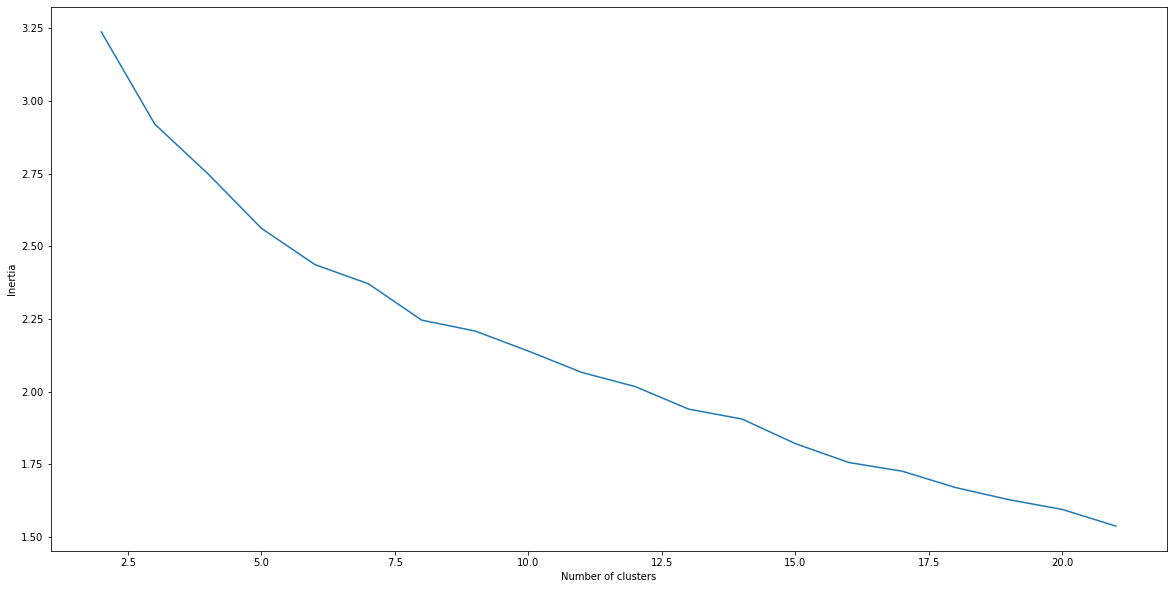

In [159]:
kmeans_inertias = list(map(lambda x: x.inertia_, kmeans_results))
plt.figure(figsize=(20,10))
plt.plot(k_options[:20], kmeans_inertias[:20])
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

There is no clear elbow but I choose six clusters because there is a slight elbow there.

In [164]:
kclusters = 6
kmeans_chosen_result = kmeans_results[kclusters-2]
km_labels = kmeans_chosen_result.labels_
print(km_labels[:11])
swiss_cities_clustered = cities.copy()
swiss_cities_clustered['Cluster Labels'] = km_labels

[5 0 1 0 5 1 0 4 3 3 0]


Plot labels on map.

In [165]:
# create map
map_clusters = folium.Map(location=swiss_lat_lon_coords, zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = m_cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [m_colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(swiss_cities_clustered['Latitude'], swiss_cities_clustered['Longitude'], swiss_cities_clustered['Town'], swiss_cities_clustered['Cluster Labels']):
    # deal with german Umlaut characters ä, ö, ü
    town = poi.encode('ascii', 'xmlcharrefreplace').decode('utf-8')
    label = folium.Popup(town + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Analysis of the clusters by looking at cluster centers.

Train Station       0.085743
Hotel               0.081121
Swiss Restaurant    0.067634
Supermarket         0.054537
Restaurant          0.049241
dtype: float64

,Train Station,Hotel,Swiss Restaurant,Supermarket,Restaurant,Italian Restaurant,Grocery Store,Café,Bar,Bakery,Shopping Mall,Pizza Place,Fast Food Restaurant,French Restaurant,Department Store,Park,Plaza,History Museum,Beach,Liquor Store,Dessert Shop,Museum,Coffee Shop,Gym / Fitness Center,Burger Joint,Pool,Gastropub,Ski Area,Food & Drink Shop,Outdoors & Recreation,Moving Target,Photography Studio,Gas Station,Mountain,Gym,Ice Cream Shop,Scenic Lookout,Steakhouse,Diner,Electronics Store,Furniture / Home Store,Asian Restaurant,Thai Restaurant,Airport,Hardware Store,Soccer Field,Music Venue,Rest Area,Seafood Restaurant,Lake,Japanese Restaurant,Cocktail Bar,Lounge,Tram Station,Brewery,Athletics & Sports,Trail,American Restaurant,Mexican Restaurant,Art Museum,Mediterranean Restaurant,Indian Restaurant,Castle,Golf Course,Bowling Alley,Convenience Store,Chocolate Shop,Bistro,Sushi Restaurant,German Restaurant,Soccer Stadium,Movie Theater,Pub,Chinese Restaurant,Science Museum,Concert Hall,Hockey Arena,Bus Station,Light Rail Station,Sandwich Place,Breakfast Spot,Historic Site,Garden,Snack Place,Wine Bar,Nightclub,Spa,Sporting Goods Shop,Farmers Market,Food Court,Tea Room,Flower Shop,Zoo,Multiplex,Theater,Modern European Restaurant,Clothing Store,Waterfront,Trattoria/Osteria,Hostel,Water Park,Resort,Miscellaneous Shop,BBQ Joint,Food,Tennis Court,Vegetarian / Vegan Restaurant,Stadium,Casino,Theme Park,Sports Bar,Discount Store,Art Gallery,Ski Chalet,Boat or Ferry,Creperie,Bookstore,Other Great Outdoors,Fondue Restaurant,Convention Center,Ski Chairlift,Hot Spring,Middle Eastern Restaurant,Event Space,Airport Lounge,Cupcake Shop,Argentinian Restaurant,Salad Place,Church,Greek Restaurant,Palace,River,Hotel Bar,Beer Garden,Harbor / Marina,Pedestrian Plaza,Campground,Candy Store,Waterfall,General Entertainment,Bed & Breakfast,Botanical Garden,Bus Stop,Forest,Gourmet Shop,Drugstore,Monument / Landmark,Platform,Toy / Game Store,Rock Climbing Spot,Turkish Restaurant,Skating Rink,Border Crossing,Cable Car,Boutique,Irish Pub,Cheese Shop,Eastern European Restaurant,Apres Ski Bar,Garden Center,Shop & Service,Wine Shop,Winery,Jewelry Store,Rock Club,Hookah Bar,Performing Arts Venue,Shoe Store,Bagel Shop,Beach Bar,Pharmacy,Racetrack,Tunnel,Tapas Restaurant,Playground,Pier,Climbing Gym,Vietnamese Restaurant,Kebab Restaurant,Pet Store,Farm,Portuguese Restaurant,Hospital,Bridge,Outdoor Sculpture,Hobby Shop,Tennis Stadium,Market,Watch Shop,Spanish Restaurant,Big Box Store,Neighborhood,Ramen Restaurant,Tourist Information Center,Scandinavian Restaurant,Zoo Exhibit,Road,Mobile Phone Shop,Perfume Shop,Bathing Area,Falafel Restaurant,Factory,Deli / Bodega,Moroccan Restaurant,Salon / Barbershop,Auto Garage,Motorcycle Shop,Community Center,Dim Sum Restaurant,Food Truck,Recreation Center,Fried Chicken Joint,Comedy Club,Coworking Space,Airport Service,Sculpture Garden,Outlet Store,Gym Pool,Indie Movie Theater,Island,Theme Park Ride / Attraction,Hotel Pool,Buffet,Organic Grocery,Juice Bar,Ski Lodge,Stables,Motel,Yoga Studio,Cafeteria,Construction & Landscaping,Arts & Crafts Store,Burrito Place,General College & University,Field,General Travel,Doner Restaurant,Nature Preserve,Korean Restaurant,Butcher,Arcade,Jewish Restaurant,Vineyard,Fountain,City,Smoke Shop,Music School,Indoor Play Area,Lighting Store,Well,Peruvian Restaurant,Tech Startup,Piano Bar,Dive Bar,Accessories Store,Comfort Food Restaurant,Cosmetics Shop,Auto Dealership,Indie Theater,Paper / Office Supplies Store,Hawaiian Restaurant,Latin American Restaurant,Circus,Canal Lock,Health & Beauty Service,Sports Club,Skate Park,Lebanese Restaurant,Bank,Whisky Bar,Cultural Center,RV Park,Pool Hall,Home Service,Car Wash,Public Art,Wings Joint,Lingerie Store,Beer Store,Fish & Chips Shop,Track Stadium,Library,Australian Restaurant,Hot Dog Joint,Men's Store,Other Nightlife,Wedding Hall,Theme Restaurant,Tree,Office,Shopping Plaza,Israeli Restaurant,Bubble Tea Shop,Dance Studio,IT Services,Exhibit,Mini Golf,Monastery,

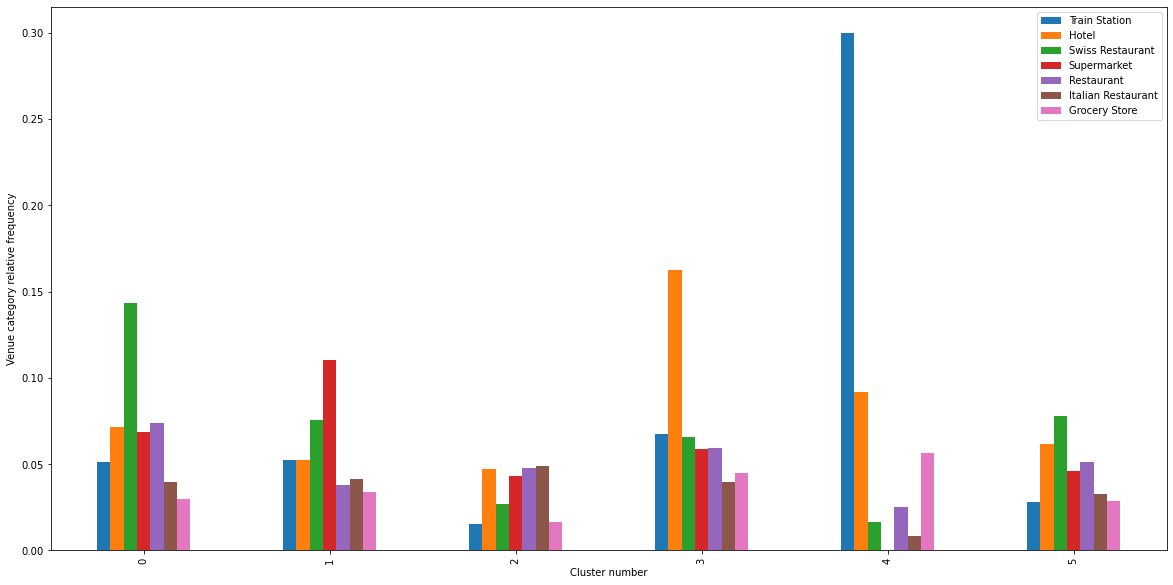

In [185]:
km_centers = kmeans_chosen_result.cluster_centers_
cluster_center_df = pd.DataFrame(km_centroids, columns = cities_features.columns)
center_of_centers_df = cluster_center_df.mean().sort_values(ascending=False)
display(center_of_centers_df.head())
cluster_center_df = cluster_center_df[center_of_centers_df.index]
display(cluster_center_df)
cluster_center_df[cluster_center_df.columns[:7]].plot(kind='bar', figsize=(20, 10))
plt.xlabel('Cluster number')
plt.ylabel('Venue category relative frequency')
plt.show()